### Deprecated

In [1]:
import pandas as pd
import geopandas as gpd
import os

# Load villages data
"VP_Village" is Value of production, it measures crop production, see Xavier

In [3]:
villages = gpd.read_file(os.path.join("..", "..", 'Structured', 'Villages', 'villages_with_2019_census.geojson'))
villages.head()

,FID_1,village_code,village,TOTPOP,commune_code,commune,VP_Village,village_nb,commune_nb,district_code,province_code,province,POP2019,geometry
0,433,01070101,Kouk Samraong Lech,923.0,010701,Banteay Chhmar,861770,01,01,0107,01,None,1045.943346,POINT (296338.9965241785 1560320.494660038)
1,434,01070102,Kbal Tonsaong,1113.0,010701,Banteay Chhmar,861770,02,01,0107,01,None,1589.543818,POINT (288890.9995685919 1559481.502582733)
2,435,01070103,Banteay Chhmar Cheung,1378.0,010701,Banteay Chhmar,861770,03,01,0107,01,None,2063.197108,POINT (294264.9940472423 1556597.498561439)
3,436,01070105,Kbal Krabei,1062.0,010701,Banteay Chhmar,861770,05,01,0107,01,None,1735.987902,POINT (302680.9855266958 1552423.492430913)
4,437,01070106,Banteay Chhmar Tboung,1900.0,010701,Banteay Chhmar,861770,06,01,0107,01,None,2966.004721,POINT (295017.9920123415 1555181.498547339)


# Load employment data from business census

In [4]:
#business_census_full = pd.read_csv(os.path.join("..", "..",  'Structured', 'BusinessCensus', 'businessCensusFull.csv'))
# Load
business_census = pd.read_csv(os.path.join("..", "..", 'Structured', 'BusinessCensus', 'businessCensus.csv'))

# Transform
business_census['village_code'] = business_census['village_code'].astype(str).str.zfill(8)
dic_sectorId_trigram = pd.read_csv(os.path.join("..", "..", 'Structured', 'InputOutputTable', 'sector_trigram.csv')).set_index('id')['trigram']
business_census['sector'] = business_census['sector_code'].map(dic_sectorId_trigram)
business_census.head()

,province_code,district_code,commune_code,village_code,block_code,sector_code,activity_code,activity_group,activity_division,activity_section,nb_workers,sales,sector
0,1,102,10201,01020101,01020101001,31,5610,561,56,I,1,5040.0,ACF
1,1,102,10201,01020101,01020101001,28,4719,471,47,G,3,3450.0,TRR
2,1,102,10201,01020101,01020101001,31,5630,563,56,I,2,1560.0,ACF
3,1,102,10201,01020101,01020101001,28,4719,471,47,G,2,9000.0,TRR
4,1,102,10201,01020101,01020101001,31,5610,561,56,I,1,1500.0,ACF


In [8]:
# Employment per village
#dic_village_employement = business_census.groupby('village_code')['nb_workers'].sum()

# There was an admin changes between pop census (2008) and business census (2011)

Check the village code we cannot map

In [6]:
condition_unmapped_firms = ~business_census['village_code'].isin(villages['village_code'])

# List villages & districts
unmapped_villages = business_census.loc[condition_unmapped_firms, 'village_code'].unique()
print("# unmapped villages:", len(unmapped_villages))
print("Unmapped districts:", business_census.loc[condition_unmapped_firms, 'district_code'].unique())

# Global gap
print("% unmapped firms:", condition_unmapped_firms.sum() / business_census.shape[0])
print("% unmapped workers:", business_census.loc[condition_unmapped_firms, "nb_workers"].sum() / business_census["nb_workers"].sum())

# Gap in affected provinces
affected_provinces = list(business_census.loc[condition_unmapped_firms, 'province_code'].unique())
print("Affected provinces:", affected_provinces)
for province in affected_provinces:
    condition_province = business_census['province_code'] == province
    pc = business_census.loc[condition_unmapped_firms & condition_province, "nb_workers"].sum() / business_census.loc[condition_province, "nb_workers"].sum()
    print("Province", province, "% unmapped workers:", pc)

# unmapped villages: 1296
Unmapped districts: [ 102  103  107  108  110  209  210  214  304  306  309  310  311  312
  316  317  402  406  506  507  602  604  606  608  703 1005 1101 1102
 1201 1205 1206 1207 1208 1209 1301 1303 1304 1408 1411 1603 1804 1905
 2202 2203 2204 2301]
% unmapped firms: 0.14254039522186193
% unmapped workers: 0.20753918691996487
Affected provinces: [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 22, 23]
Province 1 % unmapped workers: 0.21442778684874572
Province 2 % unmapped workers: 0.013975704682155915
Province 3 % unmapped workers: 0.4517071670255306
Province 4 % unmapped workers: 0.0039079461571862786
Province 5 % unmapped workers: 0.002405275016933689
Province 6 % unmapped workers: 0.005607826032774627
Province 7 % unmapped workers: 0.000552579102899839
Province 10 % unmapped workers: 0.012612218086271075
Province 11 % unmapped workers: 0.0707876370887338
Province 12 % unmapped workers: 0.4740628339004965
Province 13 % unmapped workers: 0.01758532

# Summary of admin changes

There are 358 villages of the administrative data for in which no firms were registered in the business census. We notice that some of these villages are scattered around the country, and are likely to be villages with actually no firms registered. We did not apply any correction to these data. Most of them, however, revolve around Phnom Penh and corresponds to populated areas. We need to find a way to close this gap.

On the other hand, there are 326 villages for which we have employment data in the business census but their code could not be found in the administrative data. This gap 11.2% of the total number of workers in the data.

We conclude that both data are not using the same administrative boundaries. The main difference is the new district 12-09 in the province 12 (Phnom Penh). We know that some changes were promulgated between the census data and the 2011 economic survey:
- new admin units were promulgated on 5 November 2010
- a change for Phnom Penh on 18 May 2011
Other changes then occured in 2013 and 2014 (districts 12-10, 12-11, 12-12), but the economic census uses the administrative category of 2011-2012.

We did not have official data on this, but looking at the communes of the new 12-09 districts as well as the new communes of the other districts, we propose the following changes:
- Villages of the new district 1209 will be attributed to villages of the communes 080810, 080815, 080805, 080806, 080802, 120509, 120502, 120506, 120505, 120504, 080908, 120503, 080812
- Villages of the new communes 120516, 120517, 120518, 120519, 120520 will be attributed to villages of the communes 080110, 080126, 081019, 080124, 080114
- Villages of the new communes 120609, 120610, 120611, 120612 will be attributed to villages of the communes 080210, 080205, 080209, 080212
- Villages of the new communes 120713, 120714 will be attributed to villages of the communes 080701, 080702 in proportion of their size
- Villages of the new communes 120804, 120805, 120806 will be attributed to villages of the communes 120511, 080909, 080912 in proportion of their size (120804 to 120511)
- Many villages were added to the communes 120601, 120602, 120603, 120605, 120606. It seems that these are simply new villages and that the boundaries of the communes did not changes:
    - Villages '12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116' will be attributed to villages of the commune 120601 in proportion of their size.
    - Villages '12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215' will be attributed to villages of the commune 120602 in proportion of their size.
    - Villages '12060305', '12060306' will be attributed to villages of the commune 120603 in proportion of their size.
    - Villages '12060504', '12060505', '12060506' will be attributed to villages of the commune 120605 in proportion of their size.
    - Villages '12060603', '12060604', '12060605', '12060606', '12060607' will be attributed to villages of the commune 120606 in proportion of their size.
    
In the other provinces, the villages that could not be found in the 2008 administrative category were simply attributed to the other villages in the same communes. See the following details.
- District 0107
    - Village '01070116' Will be attributed to the villages of the commune 010701 according to their relative size. New village added at the end of the list.
- District 0108
    - Village '01080310' Will be attributed to the villages of the commune 010803 according to their relative size. New village added at the end of the list.
- District 0110
    - Villages '01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220' will be attributed to the villages of the commune 011002 according to their relative size. New villages added at the end of the list.
- District 0210
    - Village '02100306' will be attributed to the villages of the commune 021003 according to their relative size. New village added at the end of the list.
    - Village '02100404' will be attributed to the villages of the commune 021004 according to their relative size. New village added at the end of the list.
    - Village '02100608' will be attributed to the villages of the commune 021006 according to their relative size. New village added at the end of the list.
- District 0602
    - Village '06020607' will be attributed to the villages of the commune 060206 according to their relative size. New village added at the end of the list.
- District 0703
    - Village '07030202' will be attributed to the villages of the commune 070302 according to their relative size. This village is missing in the list.
    - Village '07030903' will be attributed to the villages of the commune 070309 according to their relative size. This village is missing in the list.
- District 2202
    - Village '22020427' will be attributed to the villages of the commune 220204 according to their relative size. New village added at the end of the list.
- District 1303
    - Village '13030209', '13030210', '13030211', '13030212', '13030213', '13030214' will be attributed to the villages of the commune 130302 according to their relative size. New village added at the end of the list.
    - Village '13030605', '13030606', '13030607' will be attributed to the villages of the commune 130306 according to their relative size. New village added at the end of the list.

# Implement admin change

In [37]:
def assignEmployment(village_df, dic_village_employement, sources, targets, add=False, metric_colname="Employment"):
    '''Assign employment from the source villages (from the business census)
    to the target villages (of the pop census)
    
    Sources and targets are lists of either villages, communes, or district
    If it is a list of communes or districts, then it means that it concerns 
    all villages of those communues of districts.
    
    Assignment is done as follows:
        - we sum the employment of the source villages
        - we assigne this sum to each target villages, in proportion of their population
        
    When add=False, we assume that there were no existing employement assigned to the target.
    Their employement comes completely from the sources.
    
    But if add=True, then we add the employement of the source to existing employment of the targets.
    '''
    # Determine what is the source admin unit (length 8 = villages, length 6 communes, length 4 districts)
    source_admin = len(sources[0])
    # Sum the source employment
    source_employment = sum([
        dic_village_employement[village] 
        for village in dic_village_employement.keys() 
        if village[:source_admin] in sources
    ])
    # Identify target villages
    target_admin = len(targets[0])
    cond = villages['VILL_CODE'].str[:target_admin].isin(targets)
    # Assign employement
    # either by adding it to preexisting employment
    if add:
        if village_df.loc[cond, metric_colname].isnull().any():
            print('WARNING: some of the target villages '+str(targets)+' do not have any employment')
        village_df.loc[cond, metric_colname] = village_df.loc[cond, metric_colname] \
            + (village_df.loc[cond, 'TOTPOP'] / village_df.loc[cond, 'TOTPOP'].sum()) * source_employment
        
    # or by replacing it completely
    else:
        if village_df.loc[cond, metric_colname].sum() > 0:
            print('WARNING: the target villages have already some employment')
        village_df.loc[cond, metric_colname] = \
            (village_df.loc[cond, 'TOTPOP'] / village_df.loc[cond, 'TOTPOP'].sum()) * source_employment
        # Check
        if abs(village_df.loc[cond, metric_colname].sum() - source_employment) > 1e-6:
            raise ValueError('Wrong assignement')
            
            
            
def mapMetricThroughAdminChange(villages, dic_villageCode_metric, metric_colname):   
    # Create employment column
    villages[metric_colname] = None

    # Villages whose code did not change
    villages[metric_colname] = villages['VILL_CODE'].map(dic_villageCode_metric)

    # 1. New district 1209
    # Villages of the new district 1209 will be attributed to villages of the communes 
    # 080810, 080815, 080805, 080806, 080802, 120509, 120502, 120506, 120505, 120504, 080908, 120503, 080812
    sources = ["1209"]
    targets = ['080810', '080815', '080805', '080806', '080802', '120509', '120502', 
                       '120506', '120505', '120504', '080908', '120503', '080812']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, metric_colname=metric_colname)

    # 2. Transfer of communes
    # Villages of the new communes 120516, 120517, 120518, 120519, 120520 will be attributed 
    # to villages of the communes 080110, 080126, 081019, 080124, 080114
    sources = ['120516', '120517', '120518', '120519', '120520']
    targets = ['080110', '080126', '081019', '080124', '080114']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, metric_colname=metric_colname)

    # Villages of the new communes 120609, 120610, 120611, 120612 will be attributed to villages of the communes 080210, 080205, 080209, 080212
    sources = ['120609', '120610', '120611', '120612']
    targets = ['080210', '080205', '080209', '080212']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, metric_colname=metric_colname)

    # Villages of the new communes 120713, 120714 will be attributed to villages of the communes 080701, 080702 in proportion of their size
    sources = ['120713', '120714']
    targets = ['080701', '080702']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, metric_colname=metric_colname)

    # Villages of the new communes 120804, 120805, 120806 will be attributed to villages of the communes 120511, 080909, 080912 in proportion of their size (120804 to 120511)
    sources = ['120804', '120805', '120806']
    targets = ['120511', '080909', '080912']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, metric_colname=metric_colname)

    # 3. New villages in 12
    # Villages '12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116' will be added to villages of the commune 120601 in proportion of their size.
    sources = ['12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116']
    targets = ['120601']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Villages '12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215' will be attributed to villages of the commune 120602 in proportion of their size.
    sources = ['12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215']
    targets = ['120602']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Villages '12060305', '12060306' will be attributed to villages of the commune 120603 in proportion of their size.
    sources = ['12060305', '12060306']
    targets = ['120603']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Villages '12060504', '12060505', '12060506' will be attributed to villages of the commune 120605 in proportion of their size.
    sources = ['12060504', '12060505', '12060506']
    targets = ['120605']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Villages '12060603', '12060604', '12060605', '12060606', '12060607' will be attributed to villages of the commune 120606 in proportion of their size.
    sources = ['12060603', '12060604', '12060605', '12060606', '12060607']
    targets = ['120606']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # 4. New villages in the rest of the country
    # Village '01070116' Will be attributed to the villages of the commune 010701 according to their relative size.
    sources = ['01070116']
    targets = ['010701']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '01080310' Will be attributed to the villages of the commune 010803 according to their relative size.
    sources = ['01080310']
    targets = ['010803']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Villages '01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220' will be attributed to the villages of the commune 011002 according to their relative size.
    sources = ['01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220']
    targets = ['011002']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '02100306' will be attributed to the villages of the commune 021003 according to their relative size.
    sources = ['02100306']
    targets = ['021003']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '02100404' will be attributed to the villages of the commune 021004 according to their relative size.
    sources = ['02100404']
    targets = ['021004']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '02100608' will be attributed to the villages of the commune 021006 according to their relative size.
    sources = ['02100608']
    targets = ['021006']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '06020607' will be attributed to the villages of the commune 060206 according to their relative size.
    sources = ['06020607']
    targets = ['060206']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '07030202' will be attributed to the villages of the commune 070302 according to their relative size.
    sources = ['07030202']
    targets = ['070302']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '07030903' will be attributed to the villages of the commune 070309 according to their relative size.
    sources = ['07030903']
    targets = ['070309']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '22020427' will be attributed to the villages of the commune 220204 according to their relative size.
    sources = ['22020427']
    targets = ['220204']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '13030209', '13030210', '13030211', '13030212', '13030213', '13030214' will be attributed to the villages of the commune 130302 according to their relative size.
    sources = ['13030209', '13030210', '13030211', '13030212', '13030213', '13030214']
    targets = ['130302']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)

    # Village '13030605', '13030606', '13030607' will be attributed to the villages of the commune 130306 according to their relative size.
    sources = ['13030605', '13030606', '13030607']
    targets = ['130306']
    assignEmployment(villages, dic_villageCode_metric, sources, targets, add=True, metric_colname=metric_colname)
    
    # Fill missing values
    villages[metric_colname] = villages[metric_colname].fillna(0)
    
    # Check that we did not loose metric
    print("Before mapping:", sum(dic_villageCode_metric.values()))
    print("After mapping:", villages[metric_colname].sum())

In [47]:
list_sector = list(business_census['sector'].unique())

for selected_metric in ['nb_workers', 'sales']:
    
    dic_village_metric = business_census.groupby('village_code')[selected_metric].sum().to_dict()
    mapMetricThroughAdminChange(villages, dic_village_metric, selected_metric)
        
    for selected_sector in list_sector:
        print('\n'+selected_metric+' '+selected_sector)
        cond = business_census['sector'] == selected_sector
        dic_village_employement_sector = business_census[cond].groupby('village_code')[selected_metric].sum().to_dict()
        mapMetricThroughAdminChange(villages, dic_village_employement_sector, selected_metric+'_'+selected_sector)

Before mapping: 1673390
After mapping: 1673385.5565251713
Before mapping: 12154647664.55053
After mapping: 12154632830.380383


In [48]:
villages.head()

,FID_1,VILL_CODE,VILL_NAME,TOTPOP,COMM_CODE,COMM_NAME,VP_Village,geometry,nb_workers_ACF,nb_workers_TRR,...,sales_MRU,sales_INF,sales_ACC,sales_SEC,sales_MTO,sales_MPH,sales_MCO,sales_CST,nb_workers,sales
0,433,01070101,Kouk Samraong Lech,923.0,010701,Banteay Chhmar,861770,POINT (103.1135193590683 14.10648542991592),6.0,9.068088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.136176,3.784890e+04
1,434,01070102,Kbal Tonsaong,1113.0,010701,Banteay Chhmar,861770,POINT (103.0446223591451 14.09835359022575),3.0,28.082104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.164208,1.001243e+05
2,435,01070103,Banteay Chhmar Cheung,1378.0,010701,Banteay Chhmar,861770,POINT (103.0945948786621 14.07268986004097),1.0,25.101652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.203305,2.334574e+05
3,436,01070105,Kbal Krabei,1062.0,010701,Banteay Chhmar,861770,POINT (103.172809814704 14.03557064623327),0.0,9.078342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.156683,4.852582e+04
4,437,01070106,Banteay Chhmar Tboung,1900.0,010701,Banteay Chhmar,861770,POINT (103.1016716126488 14.05994847587662),23.0,96.140159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.280319,2.510258e+06


# Export

In [49]:
export_filename_no_extension = os.path.join('..', '..', 'Structured', 'Villages', 'villages_with_full_info')
villages.to_file(export_filename_no_extension+'.geojson', driver="GeoJSON", encoding="utf-8")
villages.drop(columns='geometry').to_csv(export_filename_no_extension+'.csv', encoding="utf-8")

# Adjust sales and nb_workers per village

In [ ]:
# we need to map each value of sectoral nb workers as we did for the nb_workers...
# then export those information
# then load it into road_nodes od_points

In [47]:
villages.head()

,FID_1,VILL_CODE,VILL_NAME,TOTPOP,COMM_CODE,COMM_NAME,VP_Village,geometry,Employment
0,433,01070101,Kouk Samraong Lech,923.0,010701,Banteay Chhmar,861770,POINT (296338.9965241785 1560320.494660038),17.136176
1,434,01070102,Kbal Tonsaong,1113.0,010701,Banteay Chhmar,861770,POINT (288890.9995685919 1559481.502582733),54.164208
2,435,01070103,Banteay Chhmar Cheung,1378.0,010701,Banteay Chhmar,861770,POINT (294264.9940472423 1556597.498561439),74.203305
3,436,01070105,Kbal Krabei,1062.0,010701,Banteay Chhmar,861770,POINT (302680.9855266958 1552423.492430913),19.156683
4,437,01070106,Banteay Chhmar Tboung,1900.0,010701,Banteay Chhmar,861770,POINT (295017.9920123415 1555181.498547339),184.280319


In [70]:
# evalute "adjustment factor" to apply to the business census data to match the village admin structure
employment_table = pd.concat([
    villages.set_index('VILL_CODE')['Employment'],
    business_census.groupby('village_code')['nb_workers'].sum()
], axis=1, sort=True).fillna(0)
employment_table.head()

employment_table['ratio'] = employment_table['Employment'] / employment_table['nb_workers']
#employment_table['ratio'].fillna(0)
employment_table.head()
employment_table[employment_table['ratio']<1]

,Employment,nb_workers,ratio
01070116,0.0,2.0,0.0
01080310,0.0,21.0,0.0
01100212,0.0,627.0,0.0
01100213,0.0,1334.0,0.0
01100214,0.0,560.0,0.0
01100215,0.0,405.0,0.0
01100216,0.0,5117.0,0.0
01100217,0.0,881.0,0.0
01100218,0.0,722.0,0.0
01100219,0.0,78.0,0.0


In [41]:
# use trigrams instead of sector code
mapping_dic = pd.read_csv(os.path.join(folder, "Data", "Structured", "InputOutputTable", "sector_trigram.csv")).set_index('id')["trigram"].to_dict()
business_census['sector'] = business_census['sector_code'].map(mapping_dic)

In [44]:
business_census

,province_code,district_code,commune_code,village_code,block_code,sector_code,activity_code,activity_group,activity_division,activity_section,nb_workers,sales,sector
0,1,102,10201,01020101,01020101001,31,5610,561,56,I,1,5040.000000,ACF
1,1,102,10201,01020101,01020101001,28,4719,471,47,G,3,3450.000000,TRR
2,1,102,10201,01020101,01020101001,31,5630,563,56,I,2,1560.000000,ACF
3,1,102,10201,01020101,01020101001,28,4719,471,47,G,2,9000.000000,TRR
4,1,102,10201,01020101,01020101001,31,5610,561,56,I,1,1500.000000,ACF
5,1,102,10201,01020101,01020101001,28,4719,471,47,G,1,9720.000000,TRR
6,1,102,10201,01020101,01020101001,31,5610,561,56,I,1,1680.000000,ACF
7,1,102,10201,01020101,01020101001,28,4719,471,47,G,2,9984.000000,TRR
8,1,102,10201,01020101,01020101001,28,4719,471,47,G,1,6900.000000,TRR
9,1,102,10201,01020101,01020101001,28,4719,471,47,G,1,10080.000000,TRR


In [43]:
# compute sectoral info per village
sectoral_info = business_census.groupby(['village_code', 'sector'])[['sales', 'nb_workers']].sum()
# export workers
filename = os.path.join('..', '..', "Structured", "Supply", "BusinessCensus", 'workers_per_sector_per_village.csv')
sectoral_info['nb_workers'].unstack('sector').to_csv(filename)
# export sales
filename = os.path.join('..', '..', "Structured", "Supply", "BusinessCensus", 'sales_per_sector_per_village.csv')
sectoral_info['sales'].unstack('sector').to_csv(filename)

# compute sectoral info per commune
sectoral_info = business_census.groupby(['COMM_CODE', 'sector'])[['sales', 'nb_workers']].sum()
# export workers
filename = os.path.join('..', '..', "Structured", "Supply", "BusinessCensus", 'workers_per_sector_per_village.csv')
sectoral_info['nb_workers'].unstack('sector').to_csv(filename)
# export sales
filename = os.path.join('..', '..', "Structured", "Supply", "BusinessCensus", 'sales_per_sector_per_village.csv')
sectoral_info['sales'].unstack('sector').to_csv(filename)

sector,ACC,ACF,AMO,ARC,BET,BUI,CON,CRE,CST,EDU,...,SOC,SPO,TEL,TRA,TRL,TRR,TRW,VET,VID,WAS
village_code,,,,,,,,,,,,,,,,,,,,,
01020101,NaN,9780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49134.0,NaN,NaN,NaN,NaN
01020102,NaN,8322.0,291197.750977,NaN,NaN,NaN,NaN,12600.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,244680.0,NaN,NaN,NaN,NaN
01020103,NaN,107016.0,2400.000000,NaN,NaN,NaN,NaN,NaN,NaN,28620.0,...,NaN,NaN,1800.0,NaN,NaN,608658.0,141000.0,NaN,NaN,NaN
01020104,NaN,20832.0,NaN,NaN,NaN,NaN,NaN,12000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,44100.0,NaN,NaN,NaN,NaN
01020105,NaN,NaN,2400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10125.0,NaN,NaN,NaN,NaN
01020106,NaN,25770.0,6000.000000,NaN,NaN,NaN,NaN,NaN,NaN,5400.0,...,NaN,NaN,NaN,NaN,NaN,100560.0,NaN,NaN,NaN,NaN
01020107,NaN,139356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7560.0,...,NaN,NaN,NaN,NaN,NaN,262572.0,NaN,NaN,NaN,NaN
01020108,NaN,660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,63780.0,NaN,NaN,NaN,NaN
01020109,NaN,NaN,16800.000000,NaN,NaN,NaN,NaN,NaN,NaN,31776.0,...,NaN,NaN,NaN,NaN,NaN,88920.0,NaN,NaN,NaN,NaN


# Deprecated

In [11]:
# Create employment column
villages['Employment'] = None

# Villages whose code did not change
villages['Employment'] = villages['VILL_CODE'].map(dic_village_employement)

# 1. New district 1209
# Villages of the new district 1209 will be attributed to villages of the communes 
# 080810, 080815, 080805, 080806, 080802, 120509, 120502, 120506, 120505, 120504, 080908, 120503, 080812
sources = ["1209"]
targets = ['080810', '080815', '080805', '080806', '080802', '120509', '120502', 
                   '120506', '120505', '120504', '080908', '120503', '080812']
assignEmployment(villages, dic_village_employement, sources, targets)

# 2. Transfer of communes
# Villages of the new communes 120516, 120517, 120518, 120519, 120520 will be attributed 
# to villages of the communes 080110, 080126, 081019, 080124, 080114
sources = ['120516', '120517', '120518', '120519', '120520']
targets = ['080110', '080126', '081019', '080124', '080114']
assignEmployment(villages, dic_village_employement, sources, targets)

# Villages of the new communes 120609, 120610, 120611, 120612 will be attributed to villages of the communes 080210, 080205, 080209, 080212
sources = ['120609', '120610', '120611', '120612']
targets = ['080210', '080205', '080209', '080212']
assignEmployment(villages, dic_village_employement, sources, targets)

# Villages of the new communes 120713, 120714 will be attributed to villages of the communes 080701, 080702 in proportion of their size
sources = ['120713', '120714']
targets = ['080701', '080702']
assignEmployment(villages, dic_village_employement, sources, targets)

# Villages of the new communes 120804, 120805, 120806 will be attributed to villages of the communes 120511, 080909, 080912 in proportion of their size (120804 to 120511)
sources = ['120804', '120805', '120806']
targets = ['120511', '080909', '080912']
assignEmployment(villages, dic_village_employement, sources, targets)

# 3. New villages in 12
# Villages '12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116' will be added to villages of the commune 120601 in proportion of their size.
sources = ['12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116']
targets = ['120601']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Villages '12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215' will be attributed to villages of the commune 120602 in proportion of their size.
sources = ['12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215']
targets = ['120602']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Villages '12060305', '12060306' will be attributed to villages of the commune 120603 in proportion of their size.
sources = ['12060305', '12060306']
targets = ['120603']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Villages '12060504', '12060505', '12060506' will be attributed to villages of the commune 120605 in proportion of their size.
sources = ['12060504', '12060505', '12060506']
targets = ['120605']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Villages '12060603', '12060604', '12060605', '12060606', '12060607' will be attributed to villages of the commune 120606 in proportion of their size.
sources = ['12060603', '12060604', '12060605', '12060606', '12060607']
targets = ['120606']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# 4. New villages in the rest of the country
# Village '01070116' Will be attributed to the villages of the commune 010701 according to their relative size.
sources = ['01070116']
targets = ['010701']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '01080310' Will be attributed to the villages of the commune 010803 according to their relative size.
sources = ['01080310']
targets = ['010803']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Villages '01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220' will be attributed to the villages of the commune 011002 according to their relative size.
sources = ['01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220']
targets = ['011002']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '02100306' will be attributed to the villages of the commune 021003 according to their relative size.
sources = ['02100306']
targets = ['021003']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)
        
# Village '02100404' will be attributed to the villages of the commune 021004 according to their relative size.
sources = ['02100404']
targets = ['021004']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '02100608' will be attributed to the villages of the commune 021006 according to their relative size.
sources = ['02100608']
targets = ['021006']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '06020607' will be attributed to the villages of the commune 060206 according to their relative size.
sources = ['06020607']
targets = ['060206']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '07030202' will be attributed to the villages of the commune 070302 according to their relative size.
sources = ['07030202']
targets = ['070302']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '07030903' will be attributed to the villages of the commune 070309 according to their relative size.
sources = ['07030903']
targets = ['070309']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '22020427' will be attributed to the villages of the commune 220204 according to their relative size.
sources = ['22020427']
targets = ['220204']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '13030209', '13030210', '13030211', '13030212', '13030213', '13030214' will be attributed to the villages of the commune 130302 according to their relative size.
sources = ['13030209', '13030210', '13030211', '13030212', '13030213', '13030214']
targets = ['130302']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# Village '13030605', '13030606', '13030607' will be attributed to the villages of the commune 130306 according to their relative size.
sources = ['13030605', '13030606', '13030607']
targets = ['130306']
assignEmployment(villages, dic_village_employement, sources, targets, add=True)

# End of useful script
# Below sandbox
# Check correlation with gridded GDP

### Load gridded gdp and transform it to vectors

In [52]:
# Load gridded GDP
import netCDF4 as nc
filename = os.path.join('C:\\', 'Users', "celian", "OneDrive", "Worldbank", "Tanzania", 'Data', 'GriddedGDP', 'GDP_PPP_1990_2015_5arcmin_v2.nc')
dataset = nc.Dataset(filename, "r", format="NETCDF4")
lats = dataset.variables['latitude'][:]  # extract/copy the data
long = dataset.variables['longitude'][:]
time = dataset.variables['time'][:]
gdp = dataset.variables['GDP_PPP'][:]  # shape is time, lat, lon as shown above
print(gdp.shape)

(26, 2160, 4320)


In [64]:
import numpy as np
np.ma.set_fill_value(gdp, np.nan)
filled_gdp = np.ma.filled(gdp)

In [77]:
# Subset to Cambodia and 2011
## get long lat from OSM
long_lim = (102.261, 107.633)
lats_lim = (10.191, 14.823)
boolindex_long = (long>long_lim[0])&(long<long_lim[1])
boolindex_lats = (lats>lats_lim[0])&(lats<lats_lim[1])
index_long = ([i for i, x in enumerate(boolindex_long) if x][0], [i for i, x in enumerate(boolindex_long) if x][-1])
index_lats = ([i for i, x in enumerate(boolindex_lats) if x][0], [i for i, x in enumerate(boolindex_lats) if x][-1])
## dataset is from 1990 to 2015. We want 2011, so we want the 22th value, so index 21
ts = 21

In [80]:
from shapely.geometry import Polygon

def createPolygonAroundLongLat(df, long_col, lat_col, deg_between_points=1):
    long0 = df['long']-deg_between_points/2
    long1 = df['long']+deg_between_points/2
    lat0 = df['lat']-deg_between_points/2
    lat1 = df['lat']+deg_between_points/2
    return [Polygon([
        (long0[i], lat0[i]), 
        (long1[i], lat0[i]), 
        (long1[i], lat1[i]), 
        (long0[i], lat1[i])
    ]) for i in range(len(long0))]

from shapely.geometry import Point
gridded_gdp_layer = gpd.GeoDataFrame({
    'long':list(long[boolindex_long].data)*sum(boolindex_lats), 
    'lat':[x for x in list(lats[boolindex_lats].data) for i in range(sum(boolindex_long))], 
    'gdp':[x for l in gdp[ts, index_lats[0]:(index_lats[1]+1), index_long[0]:(index_long[1]+1)].data.tolist() for x in l]
})
gridded_gdp_layer['geometry'] = createPolygonAroundLongLat(gridded_gdp_layer, 'long', 'lat', deg_between_points=5/60)
gridded_gdp_layer.crs = {'init': 'epsg:4326'}
print(gridded_gdp_layer.head())

         long        lat         gdp  \
0  102.291672  14.791664  57991960.0   
1  102.374985  14.791664  50964416.0   
2  102.458328  14.791664  40442508.0   
3  102.541672  14.791664  30923388.0   
4  102.624985  14.791664  59702588.0   

                                            geometry  
0  POLYGON ((102.25001 14.75000, 102.33334 14.750...  
1  POLYGON ((102.33332 14.75000, 102.41665 14.750...  
2  POLYGON ((102.41666 14.75000, 102.49999 14.750...  
3  POLYGON ((102.50001 14.75000, 102.58334 14.750...  
4  POLYGON ((102.58332 14.75000, 102.66665 14.750...  


C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Intersect with communes

In [132]:
# Find intersections of communes and gridded_gdp_layer
communes = gpd.read_file(os.path.join(folder, 'Data', 'Structured', 'Admin', 'level3_2013.shp'))
intersections = gpd.overlay(communes, gridded_gdp_layer, how='intersection')
intersections.head()

# recompute gdp to take into account grid cell that got cut
full_cell_surface = gridded_gdp_layer.area.mean()
intersections['corrected_gdp'] = intersections['gdp'] / full_cell_surface * intersections.area

# get gdp per commune
gdp_per_commune = intersections.groupby('commune_co')['corrected_gdp'].sum()

C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


### Analyse correlation with employment

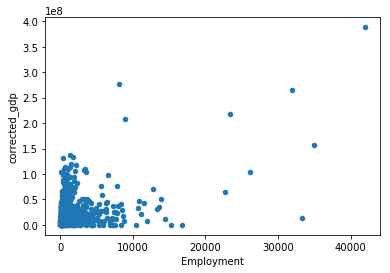

In [149]:
employment_per_commune = villages.groupby('COMM_CODE')['Employment'].sum()
employment_per_commune

comp = pd.concat([gdp_per_commune, employment_per_commune], axis=1)

comp.plot(x="Employment", y="corrected_gdp", kind='scatter')
cond = (comp['Employment'] < 20000) & (comp['corrected_gdp'] < 1.5e8)

0.08627333543309039 0.0005250693788999456
LinregressResult(slope=0.08627333543309045, intercept=-1.7859500484550043e-16, rvalue=0.08627333543309043, pvalue=0.0005250693788990036, stderr=0.024829316868268357)


C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


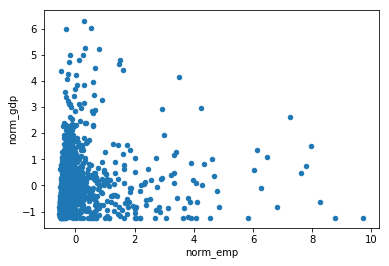

In [150]:
def normalize(series, kind='minmax'):
    if kind == "minmax":
        return (series-series.min())/(series.max()-series.min())
    if kind == "mean":
        return (series-series.mean())/series.std()
comp = comp[cond]
norm_type = "mean"
comp['norm_gdp'] = normalize(comp['corrected_gdp'], kind=norm_type)
comp['norm_emp'] = normalize(comp['Employment'], kind=norm_type)

import scipy.stats
x = comp['norm_emp']
y = comp['norm_gdp']
r, p = scipy.stats.pearsonr(x, y)
print(r, p)

print(scipy.stats.linregress(x, y))

comp.plot(x="norm_emp", y="norm_gdp", kind='scatter')

### Intersect with districts

In [147]:
# Find intersections of communes and gridded_gdp_layer
communes = gpd.read_file(os.path.join(folder, 'Data', 'Structured', 'Admin', 'level2_2013.shp'))
intersections = gpd.overlay(communes, gridded_gdp_layer, how='intersection')
intersections.head()

# recompute gdp to take into account grid cell that got cut
full_cell_surface = gridded_gdp_layer.area.mean()
intersections['corrected_gdp'] = intersections['gdp'] / full_cell_surface * intersections.area

# get gdp per district
gdp_per_district = intersections.groupby('district_c')['corrected_gdp'].sum()

C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [153]:
villages['DISC_CODE'] = villages['VILL_CODE'].str[:4]
employment_per_district = villages.groupby('DISC_CODE')['Employment'].sum()
employment_per_district

DISC_CODE
0102    10864.0
0103     2347.0
0104     4553.0
0105     3023.0
0106    11389.0
         ...   
2205     2261.0
2301     1827.0
2302     2110.0
2401     4842.0
2402     3360.0
Name: Employment, Length: 193, dtype: float64

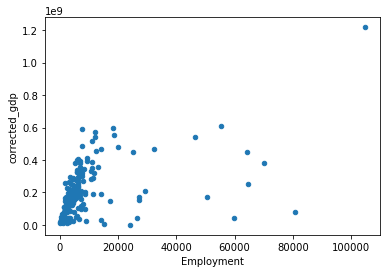

In [154]:
comp = pd.concat([gdp_per_district, employment_per_district], axis=1)

comp.plot(x="Employment", y="corrected_gdp", kind='scatter')

0.4730668869052771 1.1927324717776667e-11
LinregressResult(slope=0.47306688690527676, intercept=2.1135043037063532e-16, rvalue=0.4730668869052768, pvalue=1.1927324717777082e-11, stderr=0.06530603023642138)


C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


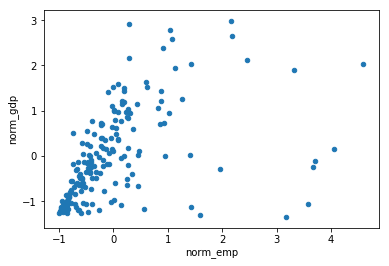

In [156]:
def normalize(series, kind='minmax'):
    if kind == "minmax":
        return (series-series.min())/(series.max()-series.min())
    if kind == "mean":
        return (series-series.mean())/series.std()

cond = (comp['Employment'] < 40000) & (comp['corrected_gdp'] < 1e9)
comp = comp[cond]

norm_type = "mean"

comp['norm_gdp'] = normalize(comp['corrected_gdp'], kind=norm_type)
comp['norm_emp'] = normalize(comp['Employment'], kind=norm_type)

import scipy.stats
x = comp['norm_emp']
y = comp['norm_gdp']
r, p = scipy.stats.pearsonr(x, y)
print(r, p)

print(scipy.stats.linregress(x, y))

comp.plot(x="norm_emp", y="norm_gdp", kind='scatter')

### Intersect with provinces

In [158]:
# Find intersections of communes and gridded_gdp_layer
communes = gpd.read_file(os.path.join(folder, 'Data', 'Structured', 'Admin', 'level1_2013.shp'))
intersections = gpd.overlay(communes, gridded_gdp_layer, how='intersection')
intersections.head()

# recompute gdp to take into account grid cell that got cut
full_cell_surface = gridded_gdp_layer.area.mean()
intersections['corrected_gdp'] = intersections['gdp'] / full_cell_surface * intersections.area

# get gdp per province
gdp_per_province = intersections.groupby('province_c')['corrected_gdp'].sum()

C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [160]:
villages['PROV_CODE'] = villages['VILL_CODE'].str[:2]
employment_per_province = villages.groupby('PROV_CODE')['Employment'].sum()
employment_per_province

PROV_CODE
01     67370.000000
02     84790.000000
03    143044.000000
04     57575.000000
05     72341.000000
06     48147.000000
07     41618.731410
08    205181.003025
09     13039.000000
10     22835.000000
11      6018.000000
12    502829.996975
13     10577.000000
14     64335.000000
15     26617.000000
16     12619.000000
17     94326.000000
18     39475.000000
19     11046.000000
20     53202.000000
21     70796.000000
22     13464.825115
23      3937.000000
24      8202.000000
Name: Employment, dtype: float64

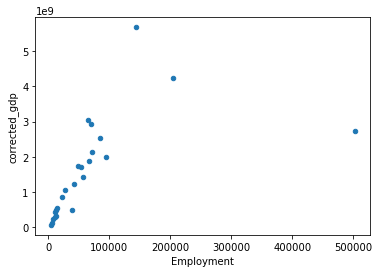

In [162]:
comp = pd.concat([gdp_per_province, employment_per_province], axis=1)

comp.plot(x="Employment", y="corrected_gdp", kind='scatter')

0.9076535768727123 5.535310515817536e-09
LinregressResult(slope=0.9076535768727121, intercept=6.412622996356592e-17, rvalue=0.9076535768727122, pvalue=5.535310515817586e-09, stderr=0.09385227338487104)


C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\celian\Anaconda3\envs\WB\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


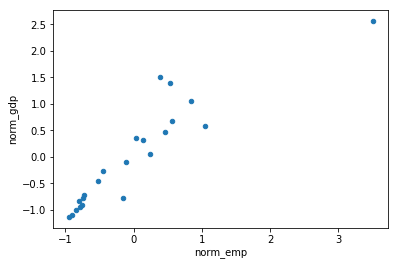

In [164]:
def normalize(series, kind='minmax'):
    if kind == "minmax":
        return (series-series.min())/(series.max()-series.min())
    if kind == "mean":
        return (series-series.mean())/series.std()
    
cond = (comp['Employment'] < 400000) & (comp['corrected_gdp'] < 5e9)
comp = comp[cond]

norm_type = "mean"

comp['norm_gdp'] = normalize(comp['corrected_gdp'], kind=norm_type)
comp['norm_emp'] = normalize(comp['Employment'], kind=norm_type)

import scipy.stats
x = comp['norm_emp']
y = comp['norm_gdp']
r, p = scipy.stats.pearsonr(x, y)
print(r, p)

print(scipy.stats.linregress(x, y))

comp.plot(x="norm_emp", y="norm_gdp", kind='scatter')

# Details: how we found out about administrative inconsistencies

In [120]:
business_census.loc[~business_census['village_code'].isin(villages['VILL_CODE']),:].head()

,province_code,district_code,commune_code,village_code,block_code,sector_code,activity_code,activity_group,activity_division,activity_section,nb_workers,sales
12544,1,107,10701,01070116,01070116001,28,4721,472,47,G,1,1680.0
12545,1,107,10701,01070116,01070116001,50,8510,851,85,P,1,360.0
13973,1,108,10803,01080310,01080310001,28,4719,471,47,G,2,4032.0
13974,1,108,10803,01080310,01080310001,28,4719,471,47,G,2,16800.0
13975,1,108,10803,01080310,01080310001,31,5610,561,56,I,1,16800.0


### Check whole new district & communes

In [121]:
set(business_census.loc[condition_unmapped_firms, 'district_code'].unique()) - set(villages['VILL_CODE'].str[:4].astype(int).sort_values().unique())

{1209}

### Tools to attribute missing villages codes

In [127]:
villages.loc[villages['VILL_CODE'].str[:6]=='080815', 'VILL_CODE']

6470    08081501
6471    08081502
6472    08081503
6473    08081504
6474    08081505
6475    08081506
6476    08081507
6477    08081508
6478    08081509
6479    08081510
6480    08081511
6481    08081512
6482    08081513
6483    08081514
6484    08081515
6485    08081516
6486    08081517
6487    08081518
Name: VILL_CODE, dtype: object

In [53]:
business_census.loc[business_census['province_code']==12, 'district_code'].unique()

array([1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209], dtype=int64)

In [126]:
condition_pp = business_census['district_code'] == 1209
set(business_census.loc[condition_pp & condition_unmapped_firms, 'village_code'].unique()) - set(villages['VILL_CODE'].astype(int).sort_values().unique())
0

set()

### Villages in the admin data with no employment data

In [122]:
# See villages
condition_noemployment_data = ~villages['VILL_CODE'].isin(business_census['village_code'])
print("Villages without employement data:", villages.loc[condition_noemployment_data].shape[0])

Villages without employement data: 358


In [123]:
# Get communes with missing villages
condition_noemployment_data = ~villages['VILL_CODE'].isin(business_census['village_code'])
villages.loc[condition_noemployment_data, "COMM_CODE"].sort_values().unique()

array(['010202', '010602', '021305', '030403', '030906', '031001',
       '031315', '031606', '040403', '040701', '050403', '060701',
       '070302', '070309', '080110', '080114', '080119', '080124',
       '080126', '080205', '080209', '080210', '080212', '080701',
       '080702', '080802', '080805', '080806', '080810', '080812',
       '080813', '080815', '080908', '080909', '080912', '090503',
       '090702', '090703', '100503', '110101', '110103', '110104',
       '110203', '110204', '110403', '120101', '120203', '120210',
       '120502', '120503', '120504', '120505', '120506', '120509',
       '120511', '140103', '140405', '150207', '160103', '160104',
       '160302', '160602', '160606', '160607', '160705', '160801',
       '160802', '160903', '160907', '171301', '180404', '190102',
       '190510', '200212', '210302', '220101', '220103', '220105',
       '220202', '220203', '220204', '220302', '220304', '220401',
       '220402', '240202'], dtype=object)

In [133]:
villages[~condition_noemployment_data & (villages['COMM_CODE']=='080802')]

,FID_1,VILL_CODE,VILL_NAME,TOTPOP,COMM_CODE,COMM_NAME,VP_Village,geometry


### Villages with employement data but not found in the admin data

In [124]:
condition_unmapped_firms = ~((business_census['village_code']).isin(villages['VILL_CODE']))
villages_not_in_admin = list(business_census.loc[condition_unmapped_firms, "village_code"].unique())
print("villages_not_in_admin:", len(villages_not_in_admin))

villages_not_in_admin: 326


### Attribute missing villages codes

District 0107
- Village '01070116' Will be attributed to the villages of the commune 010701 according to their relative size. New village added at the end of the list.

District 0108
- Village '01080310' Will be attributed to the villages of the commune 010803 according to their relative size. New village added at the end of the list.

District 0110
- Villages '01100212', '01100213', '01100214', '01100215', '01100216', '01100217', '01100218', '01100219', '01100220' will be attributed to the villages of the commune 011002 according to their relative size. New villages added at the end of the list.

District 0210
- Village '02100306' will be attributed to the villages of the commune 021003 according to their relative size. New village added at the end of the list.
- Village '02100404' will be attributed to the villages of the commune 021004 according to their relative size. New village added at the end of the list.
- Village '02100608' will be attributed to the villages of the commune 021006 according to their relative size. New village added at the end of the list.

District 0602
- Village '06020607' will be attributed to the villages of the commune 060206 according to their relative size. New village added at the end of the list.

District 0703
- Village '07030202' will be attributed to the villages of the commune 070302 according to their relative size. This village is missing in the list.
- Village '07030903' will be attributed to the villages of the commune 070309 according to their relative size. This village is missing in the list.

District 2202
- Village '22020427' will be attributed to the villages of the commune 220204 according to their relative size. New village added at the end of the list.

District 1303
- Village '13030209', '13030210', '13030211', '13030212', '13030213', '13030214' will be attributed to the villages of the commune 130302 according to their relative size. New village added at the end of the list.
- Village '13030605', '13030606', '13030607' will be attributed to the villages of the commune 130306 according to their relative size. New village added at the end of the list.

Province 12 (Phnom Penh) changes
- 1201, 1202, 1203, 1204 are unchanged
- 1205 was split between: 1205 (with part of 0801), 1209 (with part of 0808), 1211 (with parts of 0808 and 0809)
- 1206 was split between 1206 and 1212 (with part of 0802)
- 1207 was split between 1207 and 1210 (with part of 0807)
- 1208 was turned into 1208 by adding a part of 1205

District 1205
- Villages of the new communes 120516, 120517, 120518, 120519, 120520 will be attributed to villages of the district 1205 in proportion of their size.

District 1206
- Villages '12060108', '12060109', '12060110', '12060111', '12060112', '12060113', '12060114', '12060115', '12060116' will be attributed to villages of the commune 120601 in proportion of their size.
- Villages '12060206', '12060207', '12060208', '12060209', '12060210', '12060211', '12060212', '12060213', '12060214', '12060215' will be attributed to villages of the commune 120602 in proportion of their size.
- Villages '12060305', '12060306' will be attributed to villages of the commune 120603 in proportion of their size.
- Villages '12060504', '12060505', '12060506' will be attributed to villages of the commune 120605 in proportion of their size.
- Villages '12060603', '12060604', '12060605', '12060606', '12060607' will be attributed to villages of the commune 120606 in proportion of their size.
- Villages of the new communes 120609, 120610, 120611, 120612 will be attributed to villages of the districts 1206 in proportion of their size

District 1207
- Villages of the new communes 120713, 120714 will be attributed to villages of the districts 1207 in proportion of their size

District 1208
- Villages of the new communes 120804, 120805, 120806 will be attributed to villages of the districts 12008 in proportion of their size

District 1209
- Villages of the new district 1209 will be attribued to villages of the province 12 in proportion of their size

OR
- Villages of the new district 1209 will be attributed to villages of the communes 080810, 080815, 080805, 080806, 080802, 120509, 120502, 120506, 120505, 120504, 080908, 120503, 080812
- Villages of the new communes 120516, 120517, 120518, 120519, 120520 will be attributed to villages of the communes 080110, 080126, 081019, 080124, 080114
- Villages of the new communes 120609, 120610, 120611, 120612 will be attributed to villages of the communes 080210, 080205, 080209, 080212
- Villages of the new communes 120713, 120714 will be attributed to villages of the communes 080701, 080702 in proportion of their size
- Villages of the new communes 120804, 120805, 120806 will be attributed to villages of the communes 120511, 080909, 080912 in proportion of their size (120804 to 120511)

In [159]:
business_census[business_census['district_code']==1209].groupby('commune_code')['nb_workers'].sum()

commune_code
120902     7622
120903      878
120904      351
120905    63007
120906    26748
120909     2269
120911      427
120921      454
120922    10814
120923    11211
120924      239
120925      398
120926      297
Name: nb_workers, dtype: int64

In [157]:
business_census[business_census['commune_code']==120612].groupby('village_code')['nb_workers'].sum()

village_code
12061201    275
12061202    242
12061203    251
12061204    196
Name: nb_workers, dtype: int64

In [138]:
villages[~condition_noemployment_data & (villages['COMM_CODE']=='120801')]

,FID_1,VILL_CODE,VILL_NAME,TOTPOP,COMM_CODE,COMM_NAME,VP_Village,geometry
6803,8585,12080101,Phum Chres,1694.0,120801,Phnom Penh Thmei,0,POINT (484296.880 1281156.331)
6804,8586,12080102,Phum Poung Peay,2934.0,120801,Phnom Penh Thmei,0,POINT (486830.882 1279895.329)
6805,8587,12080103,Phum Damnak,1872.0,120801,Phnom Penh Thmei,0,POINT (483644.879 1278885.328)
6806,8588,12080104,Phum Bayab,3784.0,120801,Phnom Penh Thmei,0,POINT (486586.882 1281497.331)
6807,8589,12080105,Phum Phnom Penh Thmei,6016.0,120801,Phnom Penh Thmei,0,POINT (486183.882 1279555.329)
6808,8590,12080106,Phum Roang Chakr,3286.0,120801,Phnom Penh Thmei,0,POINT (485682.881 1279868.329)
6809,8591,12080107,Phum Tumnub,6851.0,120801,Phnom Penh Thmei,0,POINT (487699.062 1279088.265)
6810,8592,12080108,Phum Dei Thmei,3445.0,120801,Phnom Penh Thmei,0,POINT (485135.880 1278780.328)
6811,8593,12080109,Phum Kouk Khleang,6580.0,120801,Phnom Penh Thmei,0,POINT (483775.879 1280264.330)
6812,8594,12080110,Phum Trapeang Svay,2124.0,120801,Phnom Penh Thmei,0,POINT (485073.881 1281742.331)


### Add employment data, no adjustment of admin codes

In [143]:
dic_village_to_workers = business_census.groupby('village_code')['nb_workers'].sum()

In [144]:
villages['nb_workers'] = villages['VILL_CODE'].map(dic_village_to_workers)

In [145]:
villages.to_file(os.path.join(folder, 'Data', 'Structured', 'Villages', 'NoAdjustment', 'villages.shp'))

### Add employment per sector